<a href="https://colab.research.google.com/github/womega/Covid19_project/blob/master/Training%20and%20tuning/Training%20and%20tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Visualisation

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
url = 'https://github.com/womega/Covid19_project/blob/master/Training%20and%20tuning/final_dataset.csv?raw=true'
data = pd.read_csv(url)

In [3]:
data.head()

,Domain,Num_words,Num_chars,Hyphen,Entropy_sdsu,Entropy_nosdsu,Entropy_nosu,Tranco_Rank,Longest_word_ratio,Typos,Freenom_TLD,Other_numbers,Subdomain levels,Label
0,webmail.covid.mataroma.ma.gov.br,8,30,0,3.625807,2.155639,3.606937,0,0.218750,0,0,0,2,0
1,coronaparser.cf,3,14,0,3.189898,2.855389,2.855389,0,0.400000,0,1,0,0,1
2,coronavirus.paranavai.pr.gov.br,6,29,0,3.446807,2.281036,3.232102,0,0.354839,0,0,0,1,0
3,covid19immunitystaffing.com,6,26,0,3.912114,3.827910,3.827910,0,0.296296,0,0,0,0,1
4,covid19scanning.com,5,18,0,3.536887,3.323231,3.323231,0,0.421053,0,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67616 entries, 0 to 67615
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Domain              67616 non-null  object 
 1   Num_words           67616 non-null  int64  
 2   Num_chars           67616 non-null  int64  
 3   Hyphen              67616 non-null  int64  
 4   Entropy_sdsu        67616 non-null  float64
 5   Entropy_nosdsu      67616 non-null  float64
 6   Entropy_nosu        67616 non-null  float64
 7   Tranco_Rank         67616 non-null  int64  
 8   Longest_word_ratio  67616 non-null  float64
 9   Typos               67616 non-null  int64  
 10  Freenom_TLD         67616 non-null  int64  
 11  Other_numbers       67616 non-null  int64  
 12  Subdomain levels    67616 non-null  int64  
 13  Label               67616 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 7.2+ MB


## Countplot

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


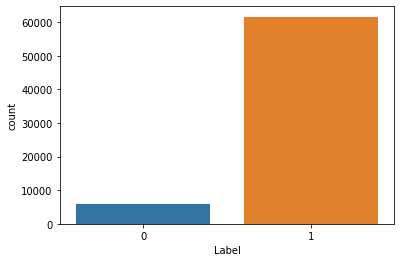

In [5]:
sns.countplot(data['Label'])

## Histograms

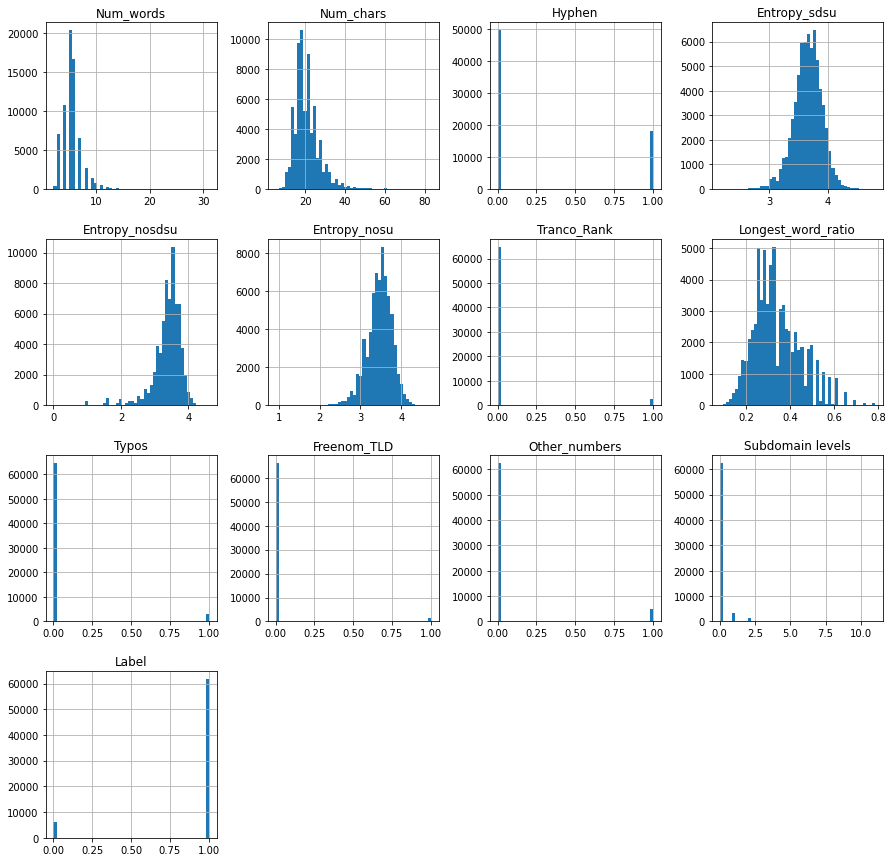

In [6]:
data.hist(bins = 50,figsize = (15,15))
plt.show()

## Correlation heatmap

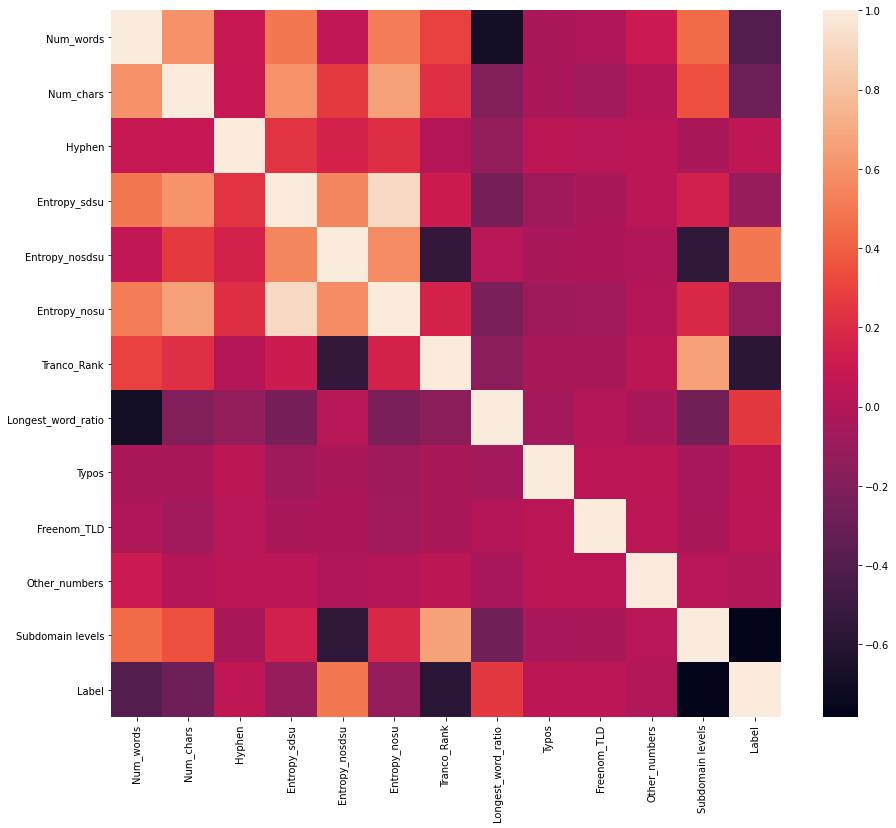

In [7]:
plt.figure(figsize=(15,13))
sns.heatmap(data.corr())
plt.show()

## Decription

In [8]:
data.describe()

,Num_words,Num_chars,Hyphen,Entropy_sdsu,Entropy_nosdsu,Entropy_nosu,Tranco_Rank,Longest_word_ratio,Typos,Freenom_TLD,Other_numbers,Subdomain levels,Label
count,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000,67616.000000
mean,5.435666,20.748506,0.267599,3.665614,3.379876,3.465380,0.040153,0.341286,0.044102,0.020823,0.074775,0.106232,0.911692
std,1.763676,6.200718,0.442711,0.236599,0.426790,0.299440,0.196320,0.108258,0.205323,0.142794,0.263030,0.411330,0.283744
min,2.000000,5.000000,0.000000,2.155639,-0.000000,0.918296,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,17.000000,0.000000,3.521641,3.238901,3.281036,0.000000,0.263158,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,20.000000,0.000000,3.682006,3.454822,3.499228,0.000000,0.322581,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.000000,24.000000,1.000000,3.825252,3.640224,3.664498,0.000000,0.407407,0.000000,0.000000,0.000000,0.000000,1.000000
max,31.000000,83.000000,1.000000,4.810857,4.602213,4.723606,1.000000,0.785714,1.000000,1.000000,1.000000,11.000000,1.000000


# Preprocessing

In [9]:
X = data.drop(['Domain', 'Label'], axis=1)
y = data['Label']

In [10]:
X.shape, y.shape

((67616, 12), (67616,))

In [11]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['black', 'red']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
        sns.despine()
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

## Undersampling

### Default NearMiss

In [12]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

X_nearmiss, y_nearmiss = NearMiss(sampling_strategy=0.25).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Counter({1: 23884, 0: 5971})


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


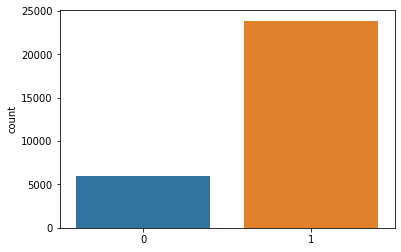

In [13]:
sns.countplot(y_nearmiss)
print(Counter(y_nearmiss))

# Algorithms

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import tree
import graphviz

In [15]:
scoring = ['precision', 'recall', 'f1', 'accuracy']

In [16]:
def append_avgs(dict):
    avgs = []
    stds = []
    for i in dict:
        avg = np.average(dict[i])
        std = np.std(dict[i])
        avgs.append(avg)
        stds.append(std)
    df = pd.DataFrame(dict)
    df.loc[10] = avgs
    df.loc[11] = stds
    return df

def get_avg(df):
    return df.iloc[[10]].reset_index(drop=True)

def draw(dict):
    folds = list(range(0,10))
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(folds,dict['test_accuracy'][:10],label='accuracy',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_precision'][:10],label = 'precision',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_f1'][:10],label = 'f1 score',marker='o', linestyle='--',)
    plt.plot(folds,dict['test_recall'][:10],label='Recall',marker='o', linestyle='--',)
    plt.xlabel('Fold')
    plt.ylabel('Performance')
    plt.xticks(folds, folds)
    plt.legend()
    plt.show()

## Decision Tree

In [17]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_nearmiss, y_nearmiss, test_size=0.333333, random_state=100)

### Baseline

#### Previously Undersampled

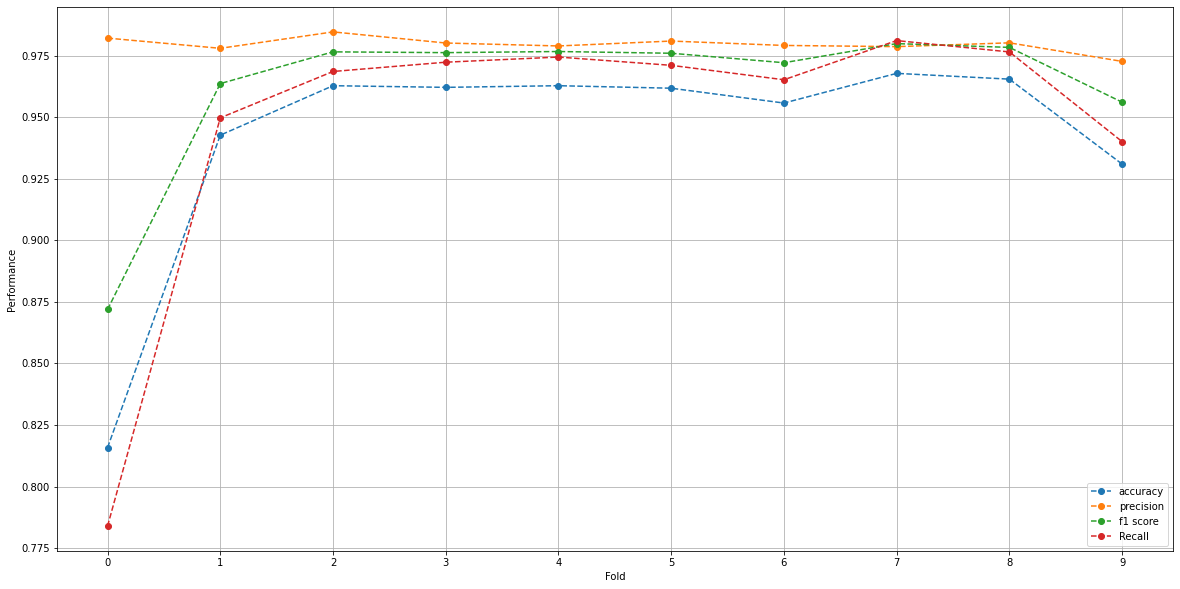

In [20]:
clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dtc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
dtc_sc_pr = append_avgs(dtc_sc_pr)
draw(dtc_sc_pr)

##### Single Model

In [21]:
# instantiate the model 
dtc = DecisionTreeClassifier()
# fit the model 

dtc.fit(X_train_1, y_train_1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
dtc_test_pred = dtc.predict(X_test_1)

print("The DTC's classification report:\n\n",classification_report(y_test_1, dtc_test_pred))
print("The DTC's confusion matrix:\n\n",confusion_matrix(y_test_1, dtc_test_pred))

The DTC's classification report:

               precision    recall  f1-score   support

           0       0.88      0.92      0.90      1976
           1       0.98      0.97      0.97      7976

    accuracy                           0.96      9952
   macro avg       0.93      0.94      0.94      9952
weighted avg       0.96      0.96      0.96      9952

The DTC's confusion matrix:

 [[1809  167]
 [ 238 7738]]


In [23]:
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names=X.columns,
                                class_names=["whitelist","malicious"],
                                filled=True, rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('test-output/decision_tree.gv', view=True)

'test-output/decision_tree.gv.pdf'

In [24]:
graph

###### Feature importance

Feature ranking:
1. Subdomain levels (0.783732)
2. Entropy_nosu (0.046301)
3. Entropy_sdsu (0.044206)
4. Entropy_nosdsu (0.038320)
5. Longest_word_ratio (0.030871)
6. Num_chars (0.025989)
7. Num_words (0.014511)
8. Tranco_Rank (0.009164)
9. Hyphen (0.004412)
10. Other_numbers (0.001387)
11. Typos (0.001106)
12. Freenom_TLD (0.000000)


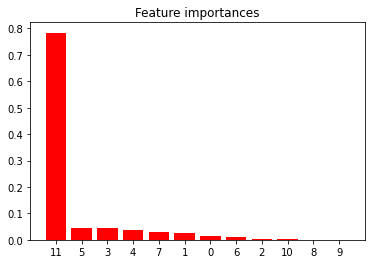

In [25]:
importances = dtc.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [26]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.33, random_state=42)

In [27]:
# build normal model
pipeline = make_pipeline(DecisionTreeClassifier())
model = pipeline.fit(X_train_2, y_train_2)
prediction = model.predict(X_test_2)

# build model with undersampling
nearmiss_pipeline = make_pipeline_imb(NearMiss(sampling_strategy=0.25, random_state=42), DecisionTreeClassifier())
nearmiss_model = nearmiss_pipeline.fit(X_train_2, y_train_2)
nearmiss_prediction = nearmiss_model.predict(X_test_2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
from imblearn.metrics import classification_report_imbalanced

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
print(classification_report_imbalanced(y_test_2, nearmiss_prediction))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.36      0.91      0.84      0.51      0.87      0.77      2000
          1       0.99      0.84      0.91      0.91      0.87      0.76     20314

avg / total       0.93      0.84      0.91      0.87      0.87      0.76     22314



In [30]:
print(accuracy_score(y_test_2, nearmiss_prediction))

0.8447611365062293


#### Undersampled in pipeline

In [31]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), DecisionTreeClassifier())
dtc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
dtc_sc = append_avgs(dtc_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

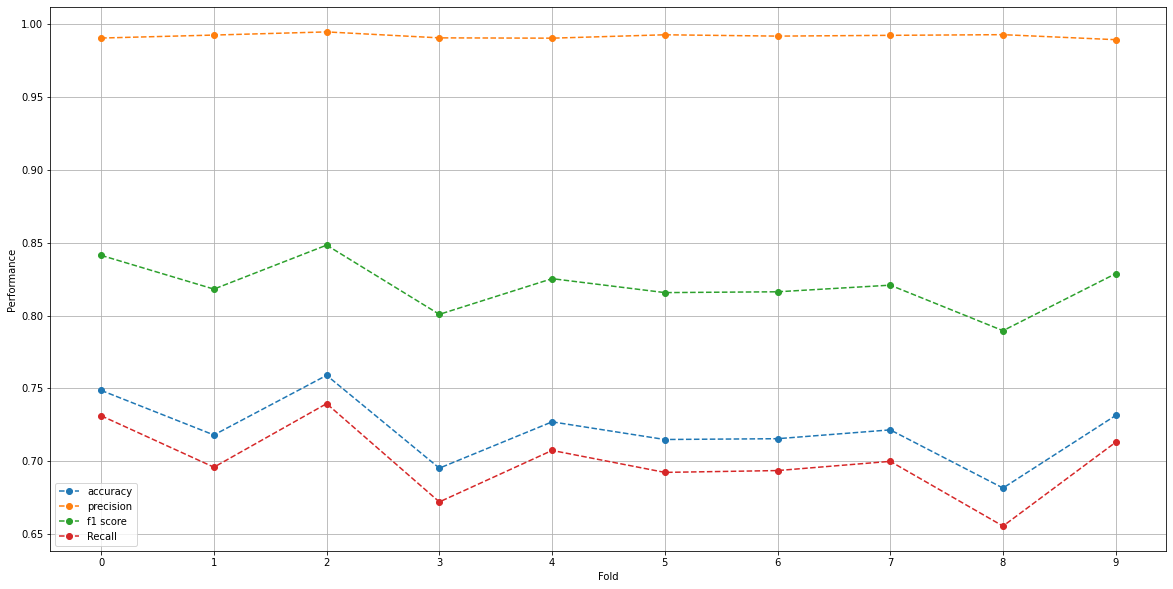

In [32]:
draw(dtc_sc)

## Random Forest

In [33]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

### Baseline

#### Previously Undersampled

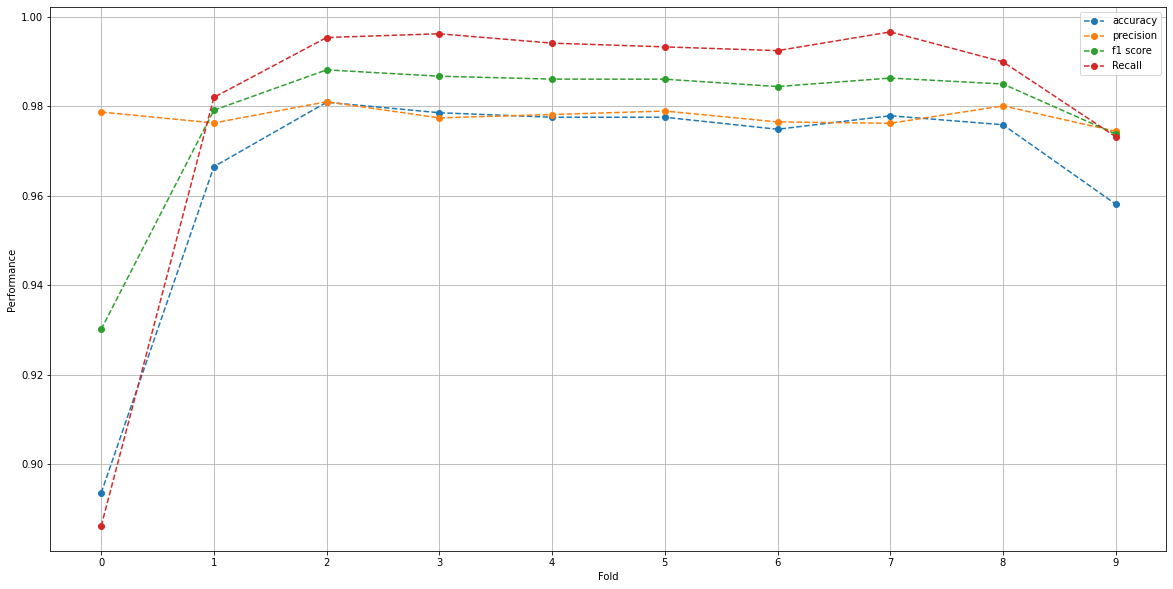

In [34]:
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
rfc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
rfc_sc_pr = append_avgs(rfc_sc_pr)
draw(rfc_sc_pr)

##### Single Model

In [35]:
# instantiate the model 
rfc = RandomForestClassifier()
# fit the model 

rfc.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
rfc_test_pred = rfc.predict(X_test_1)

print("The DTC's classification report:\n\n",classification_report(y_test_1, rfc_test_pred))
print("The DTC's confusion matrix:\n\n",confusion_matrix(y_test_1, rfc_test_pred))

The DTC's classification report:

               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1976
           1       0.98      0.99      0.98      7976

    accuracy                           0.97      9952
   macro avg       0.97      0.95      0.96      9952
weighted avg       0.97      0.97      0.97      9952

The DTC's confusion matrix:

 [[1783  193]
 [  69 7907]]


###### Feature importance

Feature ranking:
1. Subdomain levels (0.408594)
2. Entropy_nosdsu (0.165610)
3. Num_words (0.107672)
4. Tranco_Rank (0.090705)
5. Entropy_nosu (0.063592)
6. Num_chars (0.058486)
7. Entropy_sdsu (0.048327)
8. Longest_word_ratio (0.047599)
9. Hyphen (0.003996)
10. Other_numbers (0.003562)
11. Typos (0.001857)
12. Freenom_TLD (0.000000)


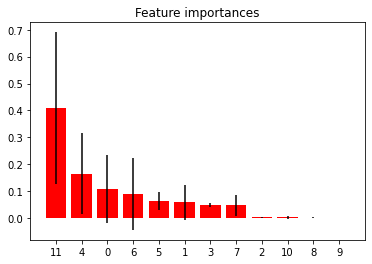

In [37]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Undersampled in pipeline

In [38]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), RandomForestClassifier())
rfc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
rfc_sc = append_avgs(rfc_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

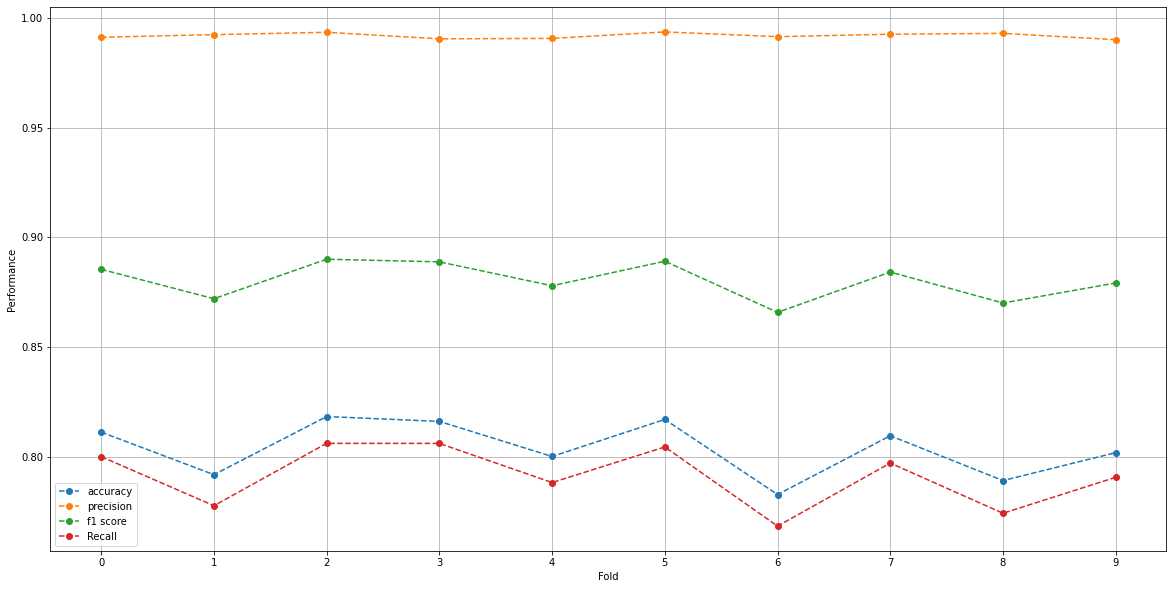

In [39]:
draw(rfc_sc)

## XGBoost

In [40]:
# XGboost classifier
from xgboost import XGBClassifier, plot_importance

### Baseline

#### Previously Undersampled

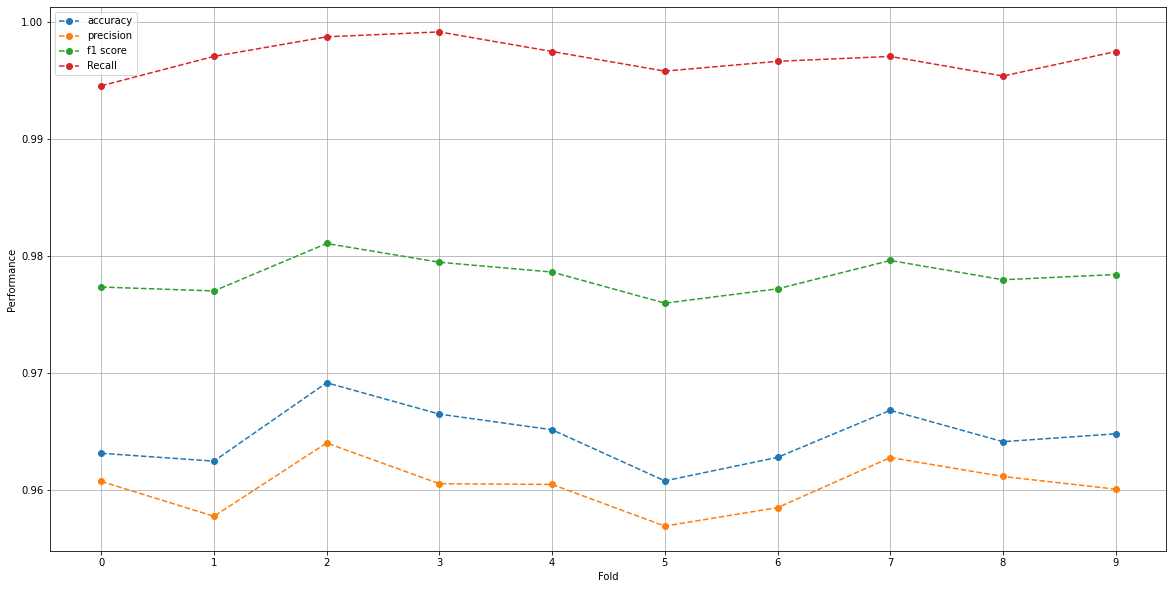

In [41]:
clf = make_pipeline(StandardScaler(), XGBClassifier())
xgb_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
xgb_sc_pr = append_avgs(xgb_sc_pr)
draw(xgb_sc_pr)

##### Single Model

In [42]:
# instantiate the model 
xgb = XGBClassifier()
# fit the model 

xgb.fit(X_train_1, y_train_1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

###### Feature importance

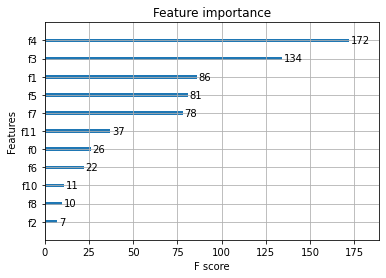

In [43]:
plot_importance(xgb)

Feature ranking:
1. Subdomain levels (0.899533)
2. Num_words (0.019364)
3. Tranco_Rank (0.018473)
4. Other_numbers (0.011468)
5. Entropy_sdsu (0.010372)
6. Entropy_nosdsu (0.010318)
7. Typos (0.009048)
8. Longest_word_ratio (0.006848)
9. Num_chars (0.006264)
10. Entropy_nosu (0.004952)
11. Hyphen (0.003360)
12. Freenom_TLD (0.000000)


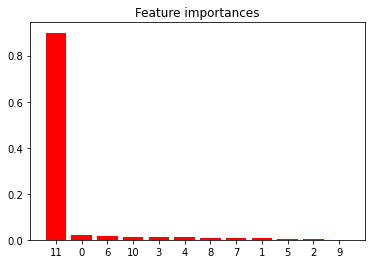

In [44]:
importances = xgb.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Undersampled in pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

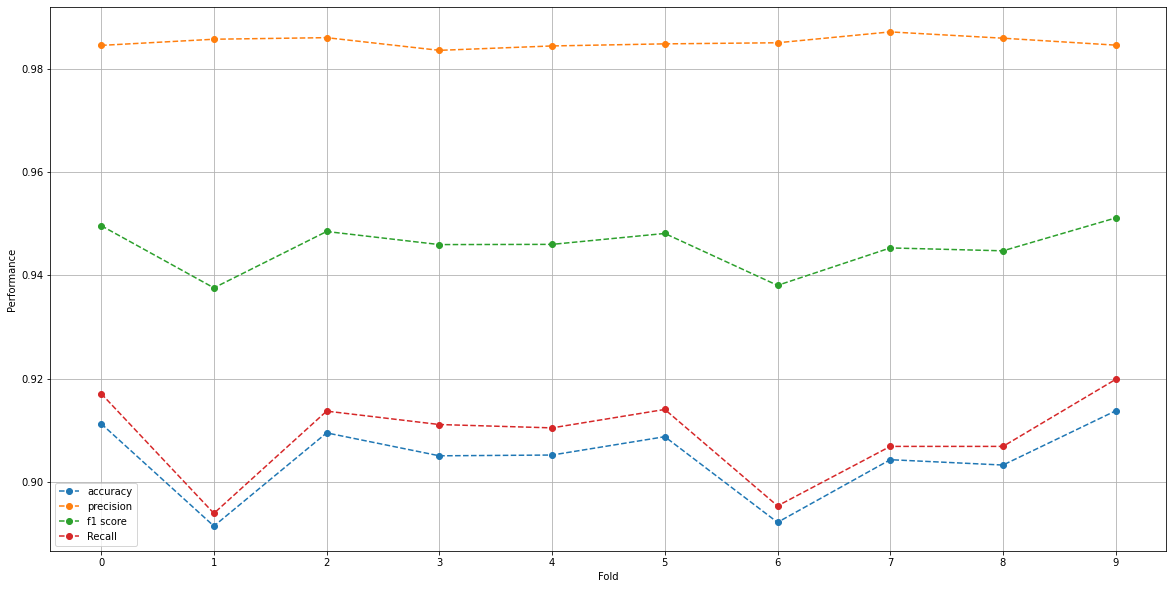

In [45]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), XGBClassifier())
xgb_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
xgb_sc = append_avgs(xgb_sc)

draw(xgb_sc)

## GBC

In [46]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

### Baseline

#### Previously Undersampled

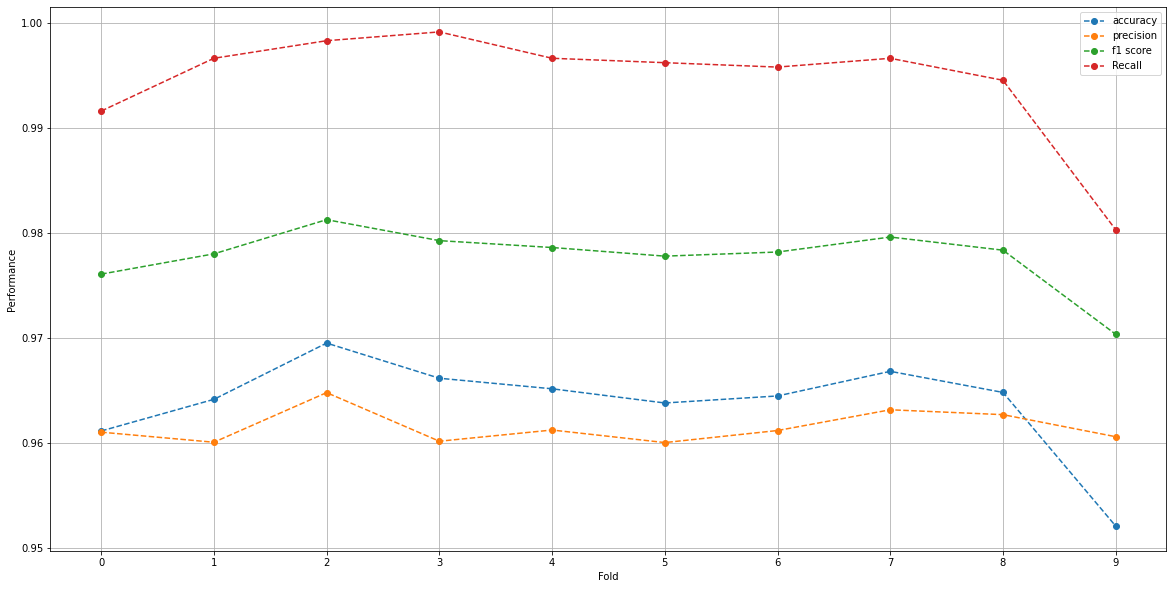

In [47]:
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gb_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
gb_sc_pr = append_avgs(gb_sc_pr)
draw(gb_sc_pr)

##### Single Model

In [48]:
# instantiate the model 
gbc = GradientBoostingClassifier()
# fit the model 

gbc.fit(X_train_1, y_train_1)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

###### Feature importance

Feature ranking:
1. Subdomain levels (0.930613)
2. Entropy_nosdsu (0.013909)
3. Entropy_nosu (0.011511)
4. Tranco_Rank (0.010518)
5. Entropy_sdsu (0.009780)
6. Num_chars (0.007504)
7. Longest_word_ratio (0.006910)
8. Num_words (0.006565)
9. Other_numbers (0.001485)
10. Typos (0.001109)
11. Hyphen (0.000095)
12. Freenom_TLD (0.000000)


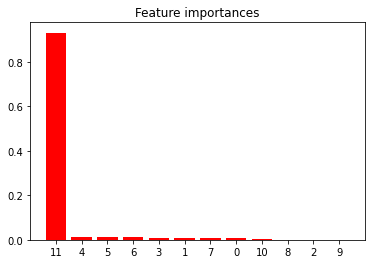

In [49]:
importances = gbc.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Undersampled in pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

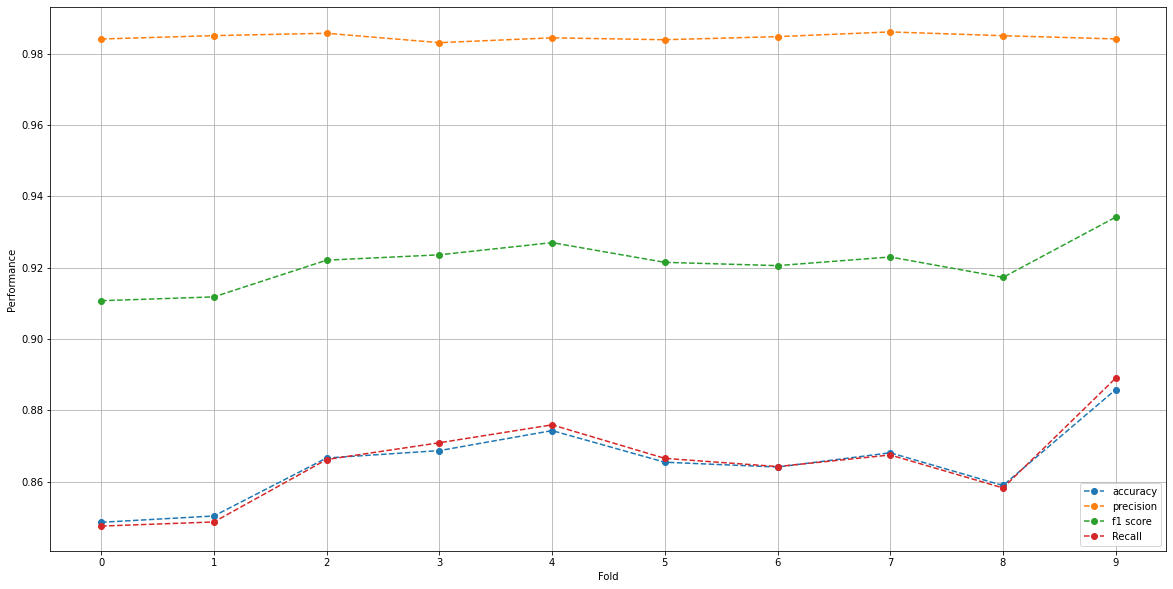

In [50]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), GradientBoostingClassifier())
gb_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
gb_sc = append_avgs(gb_sc)

draw(gb_sc)

## Perceptron

In [51]:
from sklearn.neural_network import MLPClassifier

### Baseline

#### Previously Undersampled

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


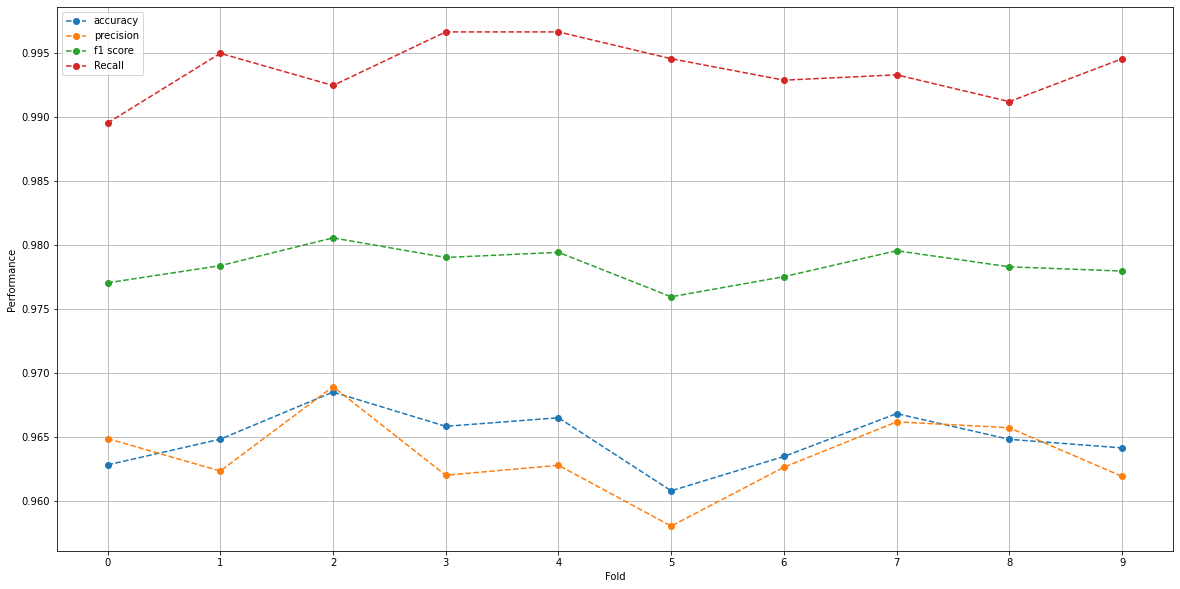

In [52]:
clf = make_pipeline(StandardScaler(), MLPClassifier())
mlp_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
mlp_sc_pr = append_avgs(mlp_sc_pr)
draw(mlp_sc_pr)

#### Undersampled in pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarnin

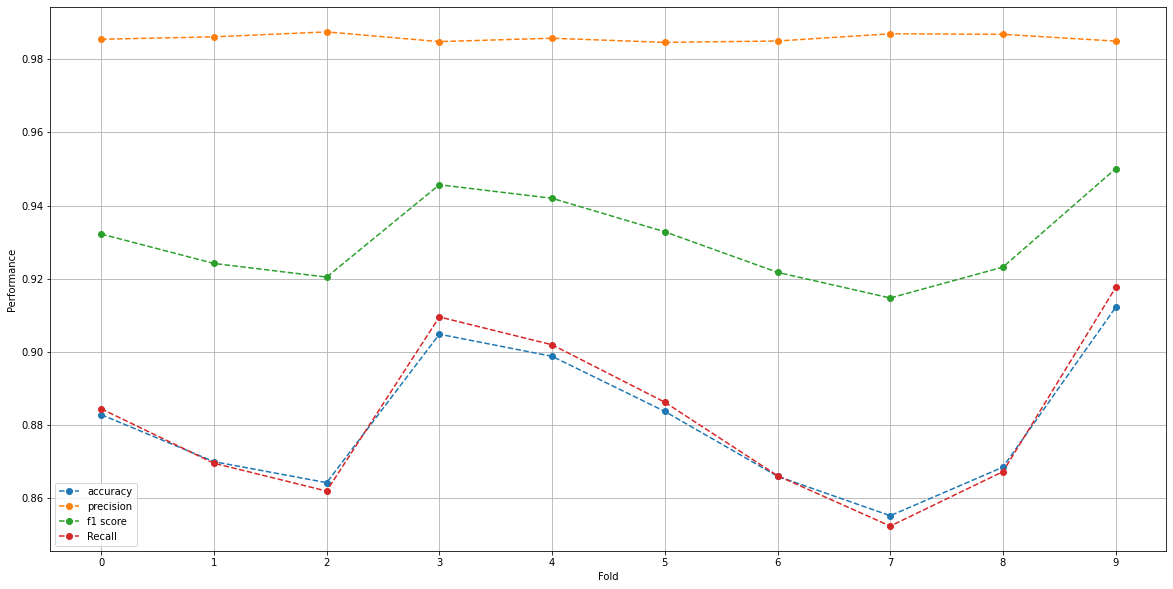

In [53]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), MLPClassifier())
mlp_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
mlp_sc = append_avgs(mlp_sc)

draw(mlp_sc)

## SVM

In [54]:
from sklearn.svm import SVC

### Baseline

#### Previously Undersampled

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

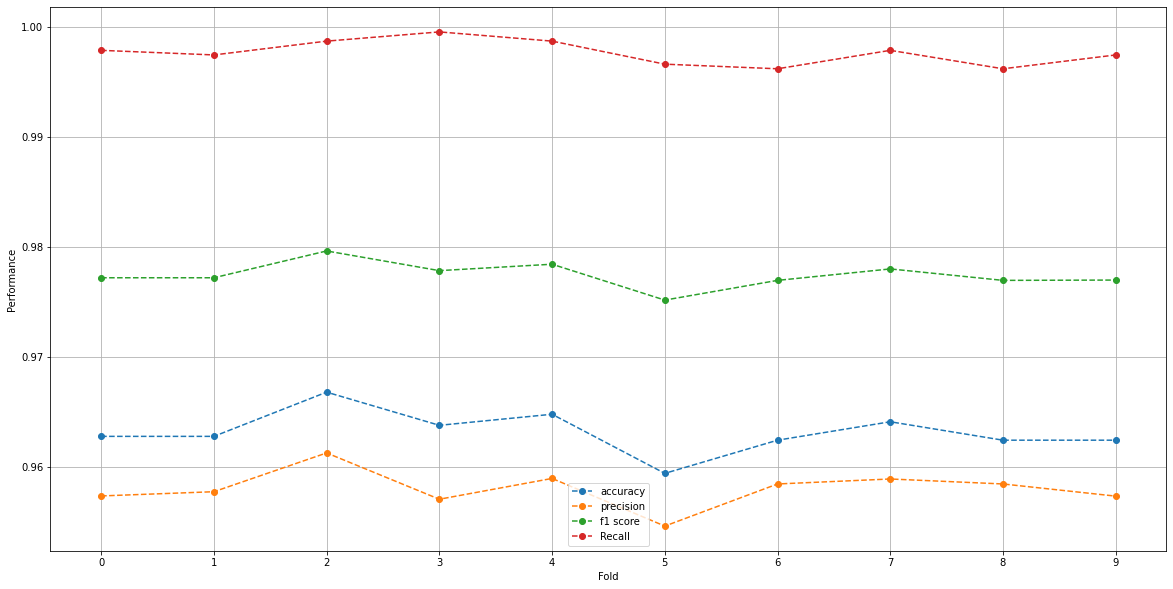

In [55]:
clf = make_pipeline(StandardScaler(), SVC(verbose=1))
svc_sc_pr = cross_validate(clf, X_nearmiss, y_nearmiss, cv=10, scoring=scoring)
svc_sc_pr = append_avgs(svc_sc_pr)
draw(svc_sc_pr)

##### Single Model

In [56]:
# instantiate the model 
svc = SVC(kernel='linear')
# fit the model 

svc.fit(X_train_1, y_train_1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

###### Feature importance

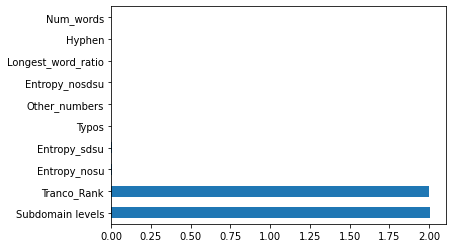

In [57]:
pd.Series(abs(svc.coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')

In [58]:
svc.coef_

array([[-1.25767432e-04, -6.62137474e-05, -2.56809383e-04,
        -4.12016819e-03, -7.91669834e-04,  5.86788357e-03,
        -2.00136682e+00,  7.64946741e-04, -1.43463931e-03,
         0.00000000e+00, -1.12708166e-03, -2.00429117e+00]])

#### Undersampled in pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibSVM]

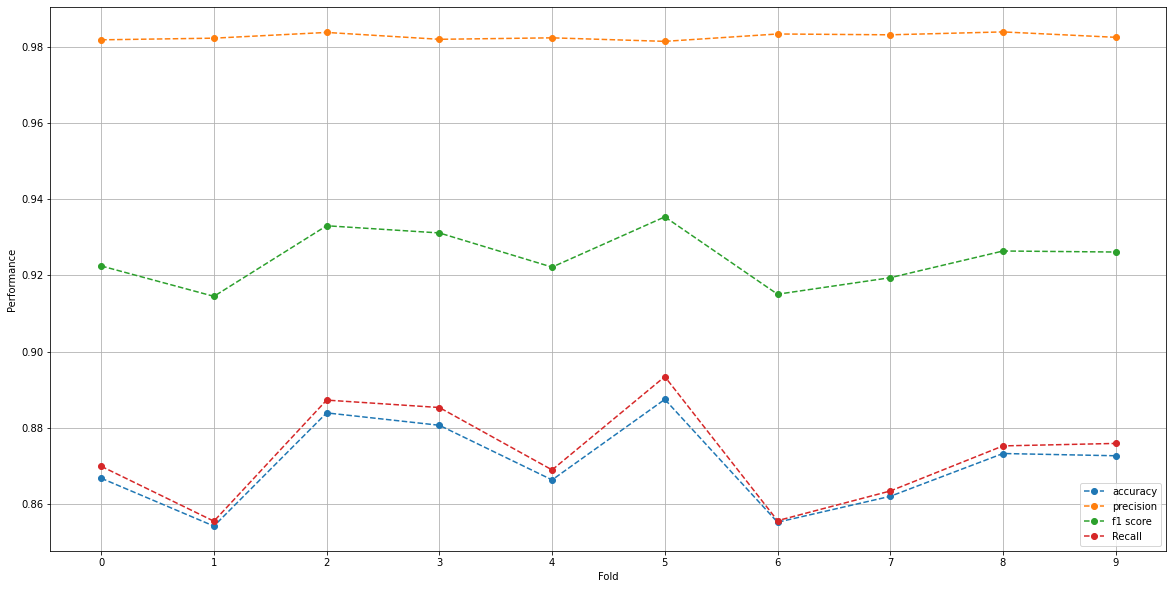

In [59]:
clf = make_pipeline_imb(NearMiss(sampling_strategy=0.5), StandardScaler(), SVC(verbose=1))
svc_sc = cross_validate(clf, X, y, cv=10, scoring=scoring)
svc_sc = append_avgs(svc_sc)

draw(svc_sc)

## Semi-supervised

In [17]:
from sklearn.metrics import make_scorer

In [18]:
url = 'https://raw.githubusercontent.com/womega/Covid19_project/master/Training%20and%20tuning/final_unlabeled.csv'

unlabeled = pd.read_csv(url)

In [19]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_nearmiss, y_nearmiss, test_size=0.333333, random_state=100)

In [20]:
df = pd.concat([pd.DataFrame(X_train_1, columns=X.columns), pd.Series(y_train_1, name='label')], axis=1)

In [21]:
unlabeled_50 = unlabeled[:10000].drop('Domain', axis=1)

In [22]:
unlabeled_50['label'] = -1

In [23]:
train = df.append(unlabeled_50)
train = train.sample(frac=1, random_state=1).reset_index(drop=True)

In [24]:
X_train = train.drop('label', axis=1)
y_train = train['label']

In [25]:

from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.preprocessing import FunctionTransformer


In [27]:
def specificity(y_true, y_pred): 
    tn = confusion_matrix(y_true, y_pred)[0, 0]
    fp = confusion_matrix(y_true, y_pred)[0, 1]
    neg = tn + fp
    return tn/neg

    
def rbf_kernel_safe(X, Y=None, gamma=None): 

      X, Y = metrics.pairwise.check_pairwise_arrays(X, Y) 
      if gamma is None: 
          gamma = 1.0 / X.shape[1] 

      K = metrics.pairwise.euclidean_distances(X, Y, squared=True) 
      K *= -gamma 
      K -= K.max()
      np.exp(K, K)
      return K


def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    print("Accuracy score on test set: "
          "%0.3f" % accuracy_score(y_test, y_pred))
    print("F1-score on test set: "
          "%0.3f" % f1_score(y_test, y_pred))
    print("Sensitivity on test set: "
          "%0.3f" % recall_score(y_test, y_pred))
    print("Specificity on test set: "
          "%0.3f" % specificity(y_test, y_pred))
    print("Precision on test set: "
          "%0.3f" % precision_score(y_test, y_pred))


In [28]:
lp_pipe = make_pipeline(StandardScaler(), LabelPropagation(kernel = 'knn'))

In [29]:
eval_and_print_metrics(lp_pipe, X_train, y_train, X_test_1, y_test_1)

Number of training samples: 29903
Unlabeled samples in training set: 10000


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning


Accuracy score on test set: 0.964
F1-score on test set: 0.978
Sensitivity on test set: 0.992
Specificity on test set: 0.849
Precision on test set: 0.964
